In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from aegomoku.gomoku_game import ConstantBoardInitializer, GomokuGame
from aegomoku.arena import Arena
from aegomoku.interfaces import MctsParams, PolicyParams
from aegomoku.gomoku_players import PolicyAdvisedGraphSearchPlayer
from pathlib import Path

In [3]:
from aegomoku.gomoku_game import RandomBoardInitializer
from aegomoku.policies.topological_value import TopologicalValuePolicy

BOARD_SIZE = 19
rbi = RandomBoardInitializer(BOARD_SIZE, 4, 7, 11, 7, 11)
the_game = GomokuGame(board_size=BOARD_SIZE, initializer=rbi)

model_file = Path.home() / "workspace" / "Project-Ellie" / "DATA" / 'models' / '1_c3.model'
mcts_challenger = MctsParams(cpuct=4.0, temperature=0, num_simulations=400)
policy_challenger = PolicyParams(model_file_name=model_file, advice_cutoff=.01)
player1 = PolicyAdvisedGraphSearchPlayer("Candidate 1_c3", the_game, mcts_challenger, policy_challenger)

mcts_champion = MctsParams(cpuct=4.0, temperature=0, num_simulations=400)
policy_champion = PolicyParams(model_file_name=None, advice_cutoff=.01)
advisor = TopologicalValuePolicy(board_size=BOARD_SIZE)
player2 = PolicyAdvisedGraphSearchPlayer("Heuristic", the_game, mcts_champion, policy_params=None, adviser=advisor)

arena = Arena(game=the_game, player1=player1, player2=player2, max_moves=100)

In [4]:
arena.play_game(verbose=2)

Heuristic to begin with black.
1: Candidate 1_c3: K11
2: Heuristic: L10
3: Candidate 1_c3: L11
4: Heuristic: M11
5: Candidate 1_c3: J8


KeyboardInterrupt: 

In [5]:
arena_file = Path.home() / "workspace" / "Project-Ellie" / "DATA" / 'arena' / '1_c3.arena'

In [ ]:
stats = arena.play_games(20, verbose=1, save_to=arena_file)

Game 1: Candidate 1_c3 to begin with black.
Candidate 1_c3 (black) won.
[I8, K10, K12, I9, H9, I10, G10, J7, E12, F11, I12, H11, G12, H12, G11, G13, G9, G8, F9, D9, H15, F13, H13, F15, F12, D12, E13, H10, D14, C15, E11, E10, E15, E14, F16, C13, G17, H18, H16, H17, G16, E16, I14, J13, I16, J16, I15, I13, J14, K13, F18]
Game 2: Candidate 1_c3 to begin with black.
Candidate 1_c3 (black) won.
[H12, K11, I10, K9, K12, J11, I12, J12, I11, I13, L10, H14, G15, I9, J10, K10, G13, F14, K8, G14, I14, J9, L9, L11, M12, N11, M11, I8, H7, H9, G9, G10, J7, I6, I7, E12, F11, K7, F7, G7, F10, H8, F8, F9, H10, E7, H13, D14, E14, J15, G12, E10, F13, H11, D15, E8, C16]
Game 3: Candidate 1_c3 to begin with black.
Candidate 1_c3 (black) won.
[J12, L12, H9, L11, L10, K11, M11, J10, M13, H8, I9, K9, M12, M10, M15, M14, G9, I11, F9, J9, E9]
Game 4: Candidate 1_c3 to begin with black.
Candidate 1_c3 (black) won.
[K12, J11, H9, J12, J13, L11, K11, K10, I8, I12, H13, L9, M8, L8, L10, H12, G12, L5, F11, J7, I14, J

In [11]:
stats

{Candidate 1_c3: 18, Heuristic: 2, 'draws': 0}

In [15]:
from pickle import Pickler

with open('1_c3.arena', 'wb+') as f:
    Pickler(f).dump(arena.games)

In [22]:
n = 0

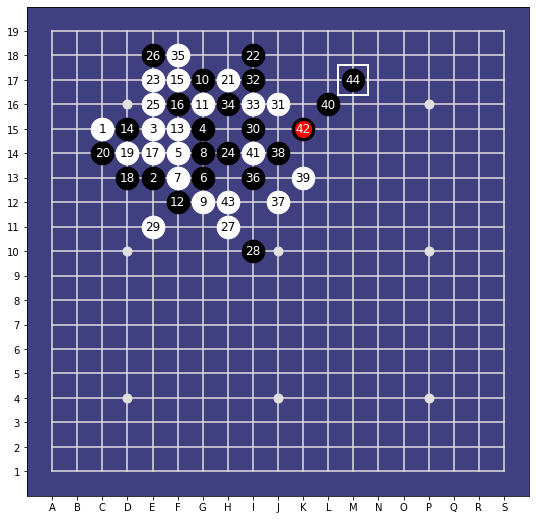

In [35]:
from aegomoku.policies.heuristic_policy import HeuristicPolicy
from aegomoku.utils import analyse_board
moves = arena.games[n]
heuristics = HeuristicPolicy(BOARD_SIZE, cut_off=0.1)
analyse_board(BOARD_SIZE, moves, heuristics, disp_width=9)
n += 1

/home/wgiersche/.local/share/virtualenvs/DeepGomoku-yQC4gx5q/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


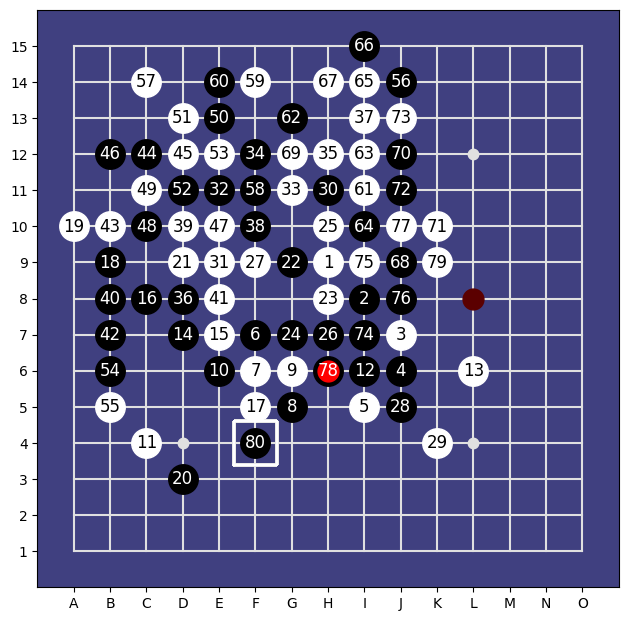

In [9]:
from aegomoku.policies.heuristic_policy import HeuristicPolicy
from aegomoku.utils import analyse_board
moves = arena.games[0]
heuristics = HeuristicPolicy(BOARD_SIZE, cut_off=0.1)
analyse_board(BOARD_SIZE, moves, heuristics, disp_width=7.5)

In [10]:
arena.max_moves

40